# Autoencoders

A lot of the code in this notebook was learned from someone that I really admire:
# Daniel Bourke (https://github.com/mrdbourke)

## 1. Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.__version__

'2.6.0+cu124'

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [ ]:
# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

## 2. Load and Prepare the MNIST Dataset

### Download the data

In [ ]:
transform = transforms.ToTensor()

# Set up training data
train_dataset = datasets.MNIST(root='mnist_data', train=True, download=True, transform=transform)

# Set up testing data
test_dataset = datasets.MNIST(root='mnist_data', train=False, download=True, transform=transform)

### Input and output shapes of data

In [ ]:
# See first training sample
img, label = train_dataset[0]
img, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [ ]:
# What's the shape of the image?
img.shape

torch.Size([1, 28, 28])

In [ ]:
# How many samples are there?
len(train_dataset.data), len(train_dataset.targets), len(test_dataset.data), len(test_dataset.targets)

(60000, 60000, 10000, 10000)

In [ ]:
# See Classes
class_names = train_dataset.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

### Visualize the data

Image shape: torch.Size([1, 28, 28])
Label: 5


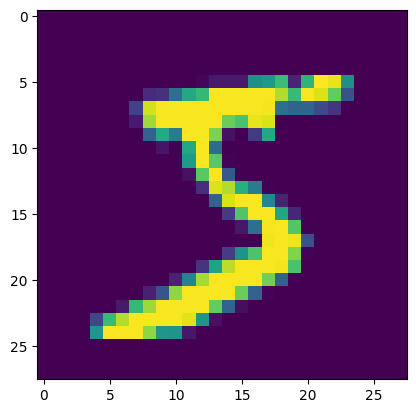

In [ ]:
img, label = train_dataset[0]
print(f"Image shape: {img.shape}")
print(f"Label: {label}")
plt.imshow(img.squeeze())
plt.show();

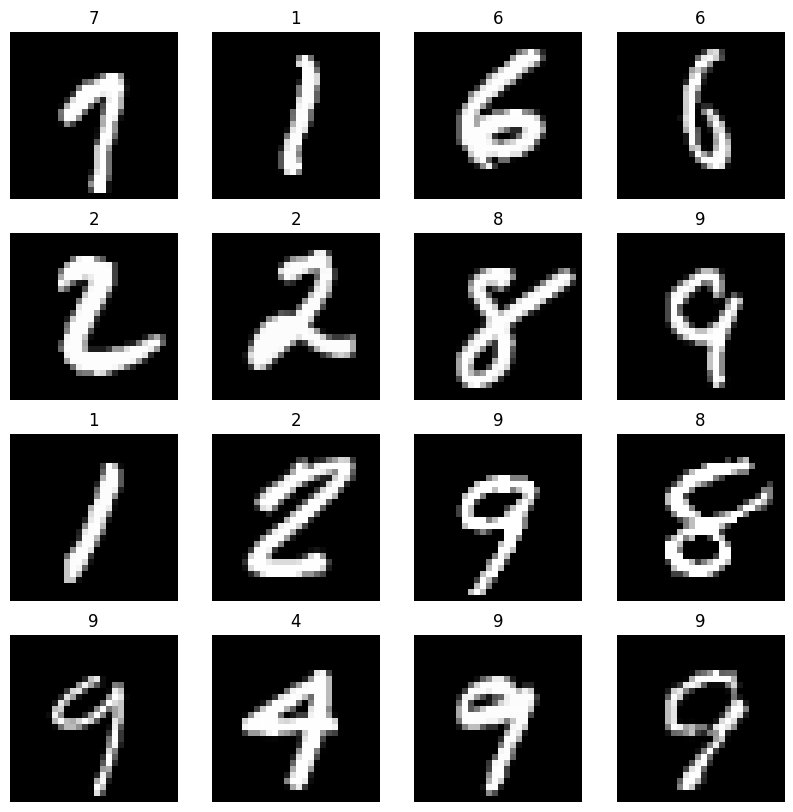

In [ ]:
# Plot more images
torch.manual_seed(56)
fig = plt.figure(figsize=(10, 10))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(label)
    plt.axis('off')
plt.show()

### Prepare dataloader

In [ ]:
# Set up the batch size
BATCH_SIZE = 128

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of size {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of size {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7ce1448d40d0>, <torch.utils.data.dataloader.DataLoader object at 0x7ce14424a3d0>)
Length of train dataloader: 469 batches of size 128
Length of test dataloader: 79 batches of size 128


In [ ]:
# Check what's inside the dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features_batch.size()}")
print(f"Labels batch shape: {train_labels_batch.size()}")

Feature batch shape: torch.Size([128, 1, 28, 28])
Labels batch shape: torch.Size([128])


Image shape: torch.Size([1, 28, 28])
Label: 1


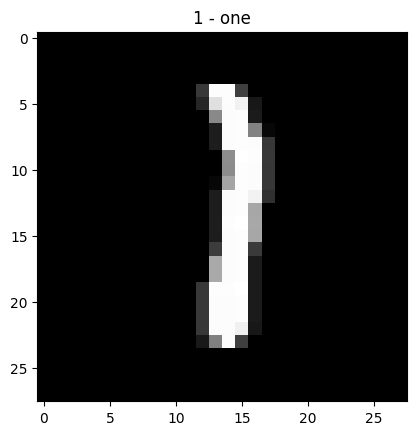

In [ ]:
# Show a sample
torch.manual_seed(56)
sample_idx = torch.randint(len(train_features_batch), size=(1,)).item()
img, label = train_features_batch[sample_idx], train_labels_batch[sample_idx]
print(f"Image shape: {img.shape}")
print(f"Label: {label}")
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.show();

## Build the Model

In [ ]:
import torch
import torch.nn as nn

class ConvAutoencoder(nn.Module):
    def __init__(self, embedding_dim=2):
        super(ConvAutoencoder, self).__init__()

        self.relu = nn.ReLU(inplace=True)

        # Encoder
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.fc_enc = nn.Linear(128 * 4 * 4, embedding_dim)

        # Decoder
        self.fc_dec = nn.Linear(embedding_dim, 128 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv_final = nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1)
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        shape_before_flattening = x.shape[1:]
        x = self.flatten(x)
        embedding = self.fc_enc(x)
        return embedding, shape_before_flattening

    def decode(self, embedding, shape_before_flattening):
        x = self.fc_dec(embedding)
        x = x.view(-1, *shape_before_flattening)
        x = self.relu(self.deconv1(x))
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x))
        x = self.sigmoid(self.deconv_final(x))
        x = x[:, :, 2:30, 2:30]
        return x

    def forward(self, x):
        embedding, shape_before_flattening = self.encode(x)
        reconstructed = self.decode(embedding, shape_before_flattening)
        return reconstructed


In [ ]:
model_0 = ConvAutoencoder(embedding_dim=2)
model_0

ConvAutoencoder(
  (relu): ReLU(inplace=True)
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_enc): Linear(in_features=2048, out_features=2, bias=True)
  (fc_dec): Linear(in_features=2, out_features=2048, bias=True)
  (deconv1): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv_final): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (sigmoid): Sigmoid()
)

In [ ]:
# Set up loss and optimizer
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model_0.parameters(), lr=0.001)

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, X)
        train_loss += loss

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    # print(f"Train loss: {train_loss:.5f}")
    return train_loss

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, X)

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        # print(f"Test loss: {test_loss:.5f}")
        return test_loss

In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
# from tqdm.auto import tqdm
# torch.manual_seed(56)

# # Measure time
# from timeit import default_timer as timer
# train_time_start_model_0 = timer()

# # Train and test model
# epochs = 10
# for epoch in tqdm(range(epochs)):
#     print(f"Epoch: {epoch}\n---------")
#     train_step(data_loader=train_dataloader,
#         model=model_0,
#         loss_fn=loss_fn,
#         optimizer=optimizer,
#         device=device
#     )
#     test_step(data_loader=test_dataloader,
#         model=model_0,
#         loss_fn=loss_fn,
#         device=device
#     )

# train_time_end_model_0 = timer()
# total_train_time_model_0 = print_train_time(start=train_time_start_model_0,
#                                            end=train_time_end_model_0,
#                                            device=device)

In [ ]:
from typing import Dict, List
from tqdm.auto import tqdm

# Import train() function from:
# https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]}
      For example if training for epochs=2:
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "test_loss": [],
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model=model,
                                           data_loader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss = test_step(model=model,
                                        data_loader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"test_loss: {test_loss:.4f} | "
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

    ### End new ###

    # Return the filled results at the end of the epochs
    return results

In [ ]:
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=10,
                        device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1851 | test_loss: 0.1843 | 
Epoch: 2 | train_loss: 0.1827 | test_loss: 0.1813 | 
Epoch: 3 | train_loss: 0.1810 | test_loss: 0.1801 | 
Epoch: 4 | train_loss: 0.1797 | test_loss: 0.1805 | 
Epoch: 5 | train_loss: 0.1785 | test_loss: 0.1794 | 
Epoch: 6 | train_loss: 0.1775 | test_loss: 0.1779 | 
Epoch: 7 | train_loss: 0.1767 | test_loss: 0.1780 | 
Epoch: 8 | train_loss: 0.1760 | test_loss: 0.1769 | 
Epoch: 9 | train_loss: 0.1755 | test_loss: 0.1768 | 
Epoch: 10 | train_loss: 0.1748 | test_loss: 0.1763 | 


In [ ]:
model_0_results

{'train_loss': [tensor(0.1851, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.1827, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.1810, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.1797, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.1785, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.1775, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.1767, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.1760, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.1755, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.1748, device='cuda:0', grad_fn=<DivBackward0>)],
 'train_acc': [],
 'test_loss': [tensor(0.1843, device='cuda:0'),
  tensor(0.1813, device='cuda:0'),
  tensor(0.1801, device='cuda:0'),
  tensor(0.1805, device='cuda:0'),
  tensor(0.1794, device='cuda:0'),
  tensor(0.1779, device='cuda:0'),
  tensor(0.1780, device='cuda:0'),
  tensor(0.1769, device='cuda:0'),
  tensor(0.1768, device='cuda:0'),
  tensor(0.1763, device='cuda:0')],
 'test_acc': 

In [ ]:
model_0_results["train_loss"]

[tensor(0.1851, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1827, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1810, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1797, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1785, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1775, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1767, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1760, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1755, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1748, device='cuda:0', grad_fn=<DivBackward0>)]

In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))  # ignore labels
train_features_batch = train_features_batch.to(device)
model_0.to(device)
model_0.eval()
with torch.inference_mode():
    reconstructed = model_0(train_features_batch)

In [ ]:
reconstructed.shape

torch.Size([128, 1, 28, 28])

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(results: dict):
    """
    Plots training and validation loss curves from a results dictionary.

    Args:
        results (dict): A dictionary containing:
                        'train_loss': list of training losses per epoch
                        'test_loss' : list of test losses per epoch
    """
    epochs = range(1, len(results['train_loss']) + 1)

    train_loss_list = [t.item() for t in results["train_loss"]]
    test_loss_list = [t.item() for t in results["test_loss"]]

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_loss_list, label='Train Loss')
    # plt.plot(epochs, train_loss_list, label='Test Loss')
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


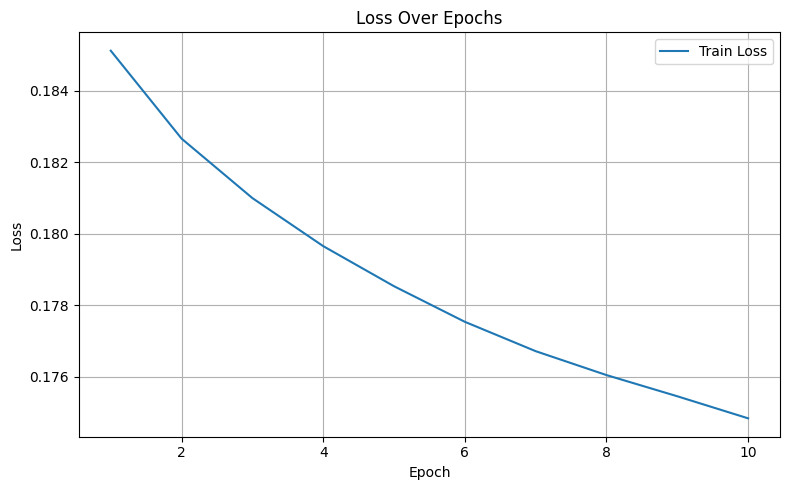

In [ ]:
plot_loss_curves(model_0_results)

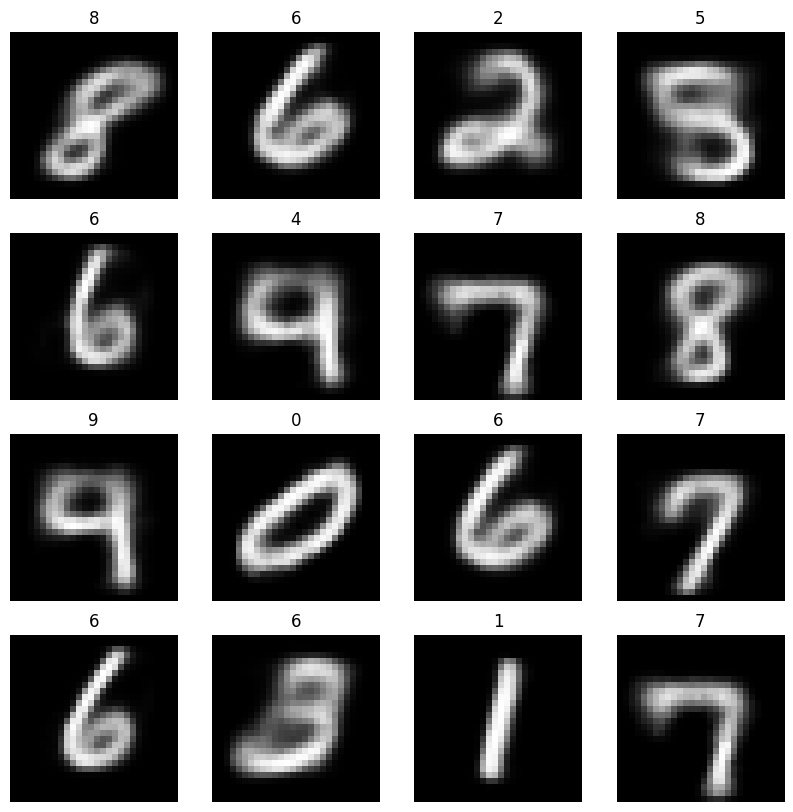

In [ ]:
# Plot more images
torch.manual_seed(56)
fig = plt.figure(figsize=(10, 10))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    img, label = reconstructed[i][0].cpu(), train_labels_batch[i].item()
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(label)
    plt.axis('off')
plt.show()